In [1]:
from files.utils.constants import *
from files.utils.utility_functions import *
from files.utils.dataset_creator import *
from files.neural_networks.base_class import *
import torch.nn as nn

In [2]:
def plot_preds_gt(ds, preds, gt):
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
    plot(ds, c='gray', alpha=0.3, ax=ax1)
    plot(ds, c='gray', alpha=0.3, ax=ax2)

    for i in range(max(gt)+1):
        if i != 0:
            X_preds = ds[preds == i]
            X_gt = ds[gt == i]
            plot(X_preds, label=f"{i}", ax=ax1)
            plot(X_gt, label=f"{i}", ax=ax2)


In [3]:
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as F
import torch.utils.data as Data
import time
from datetime import timedelta


def train(epochs, model, dataset, X_val=None, y_val=None, loss_func=None, optimizer=None, print_training=True):
    optimizer = optim.AdamW(
        model.parameters(), 1e-2) if optimizer is None else optimizer
    loss_func = torch.nn.BCELoss() if loss_func is None else loss_func

    # model.train(True)
    mean_loss_epochs = 0
    chars_to_print = 30
    loss_list_epochs = []
    accuracy_list = []

    for t in range(1, epochs+1):
        start_time = time.monotonic()
        loss_list = []

        for i, (b_x, b_y) in enumerate(dataset):
            if b_x is None or b_y is None:
                raise Exception()
            optimizer.zero_grad()   # clear gradients for next train
            # input x and predict based on x
            prediction = model(b_x)

            # b_y = b_y.unsqueeze(1)
            # print(f"Pred: {prediction.dtype}, B_Y: {b_y.dtype}")
            # must be (1. nn output, 2. target)
            loss = loss_func(prediction, b_y)
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients

            loss_list.append(loss.item())
            mean_loss_epochs = np.mean(loss_list)
            if print_training:
                perc = int(i/len(dataset) * chars_to_print)
                dt = timedelta(seconds=time.monotonic()-start_time)
                sys.stdout.write(f"\rEpoch {t}/{epochs}. Batch {i}/{len(dataset)}: [" + "="*perc + ">" + "."*(
                    chars_to_print-perc) + f"] ({int(i/len(dataset)*100)}%) ETA: {dt} Mean Loss: {mean_loss_epochs:.4f}")
                sys.stdout.flush()

        loss_list_epochs.append(loss_list)

        if X_val is not None and y_val is not None:
            with torch.no_grad():
                y_pred = model(X_val)
                correct = (torch.argmax(y_pred, dim=1) ==
                           y_val).type(torch.FloatTensor)
                accuracy_list.append(correct.mean())
        else:
            accuracy_list.append(0)

        if print_training:
            dt = timedelta(seconds=time.monotonic()-start_time)
            print(f"\rEpoch {t}/{epochs}. Batch {i+1}/{len(dataset)}: [" + "="*chars_to_print +
                  f"] (100%) ETA: {dt} Mean Loss: {mean_loss_epochs:.4f} Validation accuracy: {accuracy_list[-1]:.4f}\n")

    # model.train(False)
    return model, loss_list_epochs, accuracy_list


def project(model, point):
    point = model.tensor_from_np([point])
    for layer in model.layers:
        # if layer.out_features == 1:
        #     point = layer(point)
        #     break
        point = model.activation(layer(point))
        if layer.out_features == 1: break
    return point.detach().numpy()


class NeuralNetwork(torch.nn.Module):

    def __init__(self, input_dims, neurons=None, loss=torch.nn.BCELoss(), activation=torch.tanh):
        self.input_dims = input_dims
        self.neurons = [input_dims, 50, 50, 16,
                        1] if neurons is None else neurons
        super(NeuralNetwork, self).__init__()
        self.layers = torch.nn.ModuleList(
            [torch.nn.Linear(neuron, self.neurons[i+1]) for i, neuron in enumerate(self.neurons[:-1])])
        self.loss = loss
        self.activation = activation

    def tensor_from_np(self, arrs, debug=False):
        res = [torch.FloatTensor(arr) if arr is not None else None if not isinstance(
            arr, torch.Tensor) else arr for arr in arrs]
        if len(res) == 1:
            return res[0]
        else:
            return res

    def forward(self, x):
        x = self.tensor_from_np([x], debug=True)

        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        # yhat_batch = torch.sigmoid(self.layers[-1](x))
        yhat_batch = self.layers[-1](x)
        return yhat_batch

    def predict(self, x, return_class=True):
        x = self.tensor_from_np([x])
        # if not isinstance(x, Tensor): x = torch.FloatTensor(x)
        yhat_batch = self(x)
        if return_class:
            return torch.LongTensor([1 if yhat > 0.5 else 0 for yhat in yhat_batch]).numpy()
        else:
            return yhat_batch.detach().numpy()

    def predict_proba(self, x):
        x = self.tensor_from_np([x])
        probs = self.predict(x, return_class=False)
        return np.dstack((1-probs, probs))[:, 0, :]

    def score(self, X, y):
        X, y = self.tensor_from_np([X, y])
        y = y.unsqueeze(1)
        preds = self(X)
        l = self.loss(preds, y)
        return l.detach().numpy().mean()

    def get_params(self, deep=False):
        return {
            'input_dims': self.input_dims,
            'neurons': self.neurons,  # .numpy(),
            'loss': self.loss
        }

    def fit(self, X, y, X_val=None, y_val=None, epochs=5, lr=1e-2, bs=128, print_training=False):
        X, y, X_val, y_val = self.tensor_from_np([X, y, X_val, y_val])
        # if not isinstance(X, Tensor): X = torch.FloatTensor(X)
        # if not isinstance(y, Tensor): y = torch.FloatTensor(y)
        # if not isinstance(X_val, Tensor) and X_val is not None: X_val = torch.FloatTensor(X_val)
        # if not isinstance(y_val, Tensor) and y_val is not None: y_val = torch.FloatTensor(y_val)

        # y = torch.where(y == -1., torch.FloatTensor([0 for _ in y]), y)
        if self.loss is nn.CrossEntropyLoss():
            y = y.long()
        torch_dataset = Data.TensorDataset(X, y)  # [:,1].unsqueeze(1))
        loader = Data.DataLoader(
            dataset=torch_dataset,
            batch_size=bs,
            # num_workers=16,
            shuffle=True)

        # loss = torch.nn.CrossEntropyLoss()
        # params = list(self.parameters())# + list(loss.parameters())
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr)

        return train(epochs=epochs,
                     model=self,
                     dataset=loader,
                     X_val=X_val,
                     y_val=y_val,
                     loss_func=self.loss,
                     optimizer=optimizer,
                     print_training=print_training
                     )


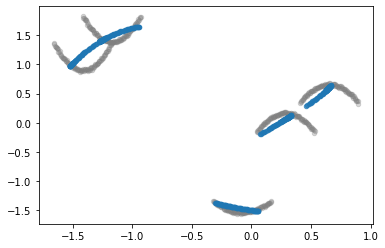

In [54]:
n_models = 5
# ds, gt = create_dataset_parabola(500, a_s=np.random.uniform(-1.5, 1.5, size=(
#     n_models)), centers=np.random.randint(-15, 15, size=(n_models, 2)), outliers_fraction=0.5)
# ds = normalize_points(ds)
# plot(ds)
idxs = np.arange(len(ds))
np.random.shuffle(idxs)
ds, gt = ds[idxs], gt[idxs]

def identity(x):    return x

net = NeuralNetwork(2, [2, 4, 1, 4, 2], loss=nn.MSELoss(), activation=torch.tanh)
net.fit(ds, ds, epochs=200, print_training=False, lr=1e-2, bs=8)

preds = net.predict(ds, return_class=False)
plot(ds, c='gray', alpha=0.3)
plot(preds)
# preds[:10]


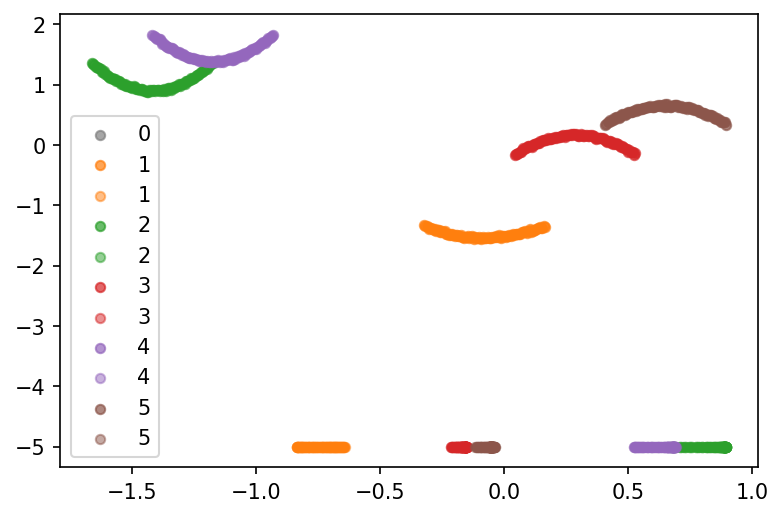

In [55]:
plt.figure(dpi=150)
projections = project(net, ds)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(max(gt)+1):
    # if i > 0:
    color = colors[i] if i > 0 else 'gray'
    alpha = 0.7 if i > 0 else 0.3

    projs = projections[gt==i]
    data = ds[gt==i]
    plot(data, label=f"{i}", c=color)
    if len(projs) > 0:
        plot(np.hstack((projs, [[-5] for _ in projs])), label=f"{i}", s=20 if i!=0 else 40, alpha=0.5, c=color)

# rand_ps = np.random.randint(0, len(ds), size=(10))

rand_ps = np.where(gt==1)
projs_lines = np.hstack((projections[rand_ps], [[-5] for _ in projections[rand_ps]]))

# plt.plot(np.vstack((ds[rand_ps][:,0], projs_lines[:,0])), np.vstack((ds[rand_ps][:,1], projs_lines[:,1])), 'b--');

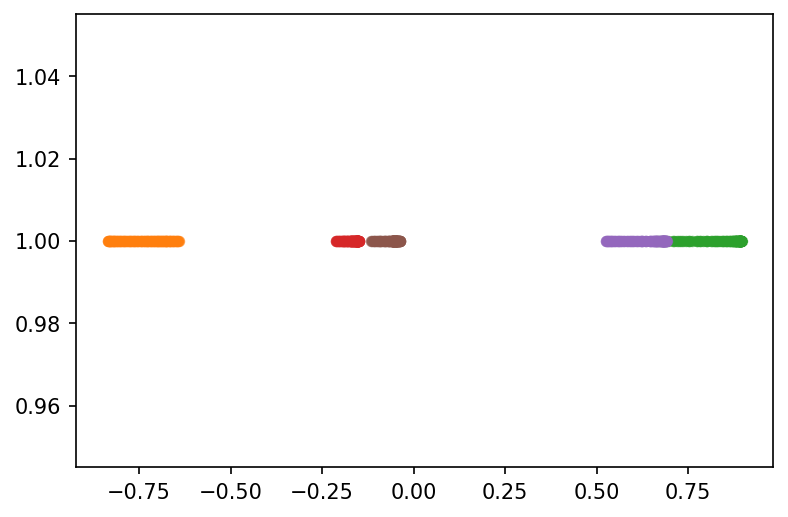

In [69]:
plt.figure(dpi=150)
projections2 = np.array([[p, 1] for i, p in enumerate(projections)], dtype=object)
for i in range(max(gt)+1):
    projs = projections2[gt == i]
    if i>0:
        plot(projs)# np.hstack((projs, np.arange(len(projs)).reshape(-1, 1))))
    else:
        plot(projs)# np.hstack((projs, np.arange(len(projs)).reshape(-1, 1))), c='gray')

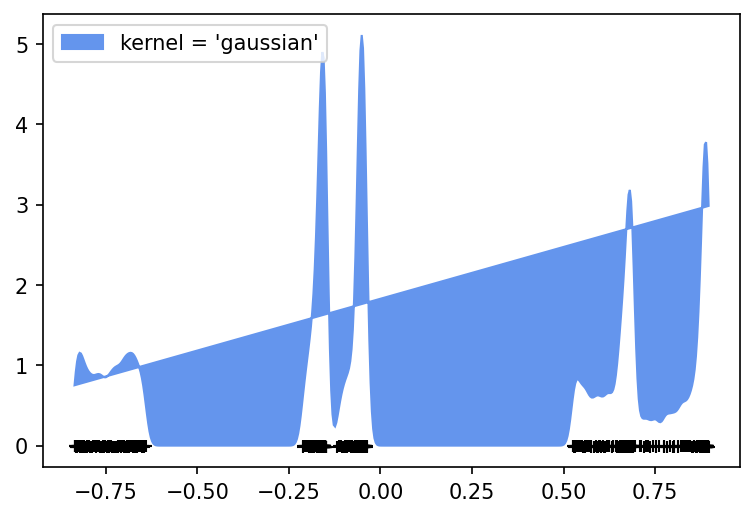

In [72]:
from sklearn.neighbors import KernelDensity
 
N = len(projections2)

X = projections2.astype(float).copy()[:,0].reshape(N, 1)
X_plot = np.linspace(X.min(), X.max(), N)[:, np.newaxis]

# X_plot.sort()
# X.sort()
fig, ax = plt.subplots(dpi=150)

colors = ["cornflowerblue", "darkorange"]
kernels = ["gaussian"]
lw = 1

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.01).fit(X)
    log_dens = kde.score_samples(X_plot)

    ax.fill(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

# ax.text(-0.7, 4.5, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

# ax.set_xlim(-1, 1)
# ax.set_ylim(-0.5, 8)
plt.show()

In [44]:
from tqdm import tqdm

n_models = 5
ds, gt = create_dataset_parabola(500, a_s=np.random.uniform(-1.5, 1.5, size=(
    n_models)), centers=np.random.randint(-15, 15, size=(n_models, 2)), outliers_fraction=0.)
ds = normalize_points(ds)
# plot(ds)
idxs = np.arange(len(ds))
np.random.shuffle(idxs)
ds, gt = ds[idxs], gt[idxs]

def identity(x):    return x

N_MODELS = 10

models = [NeuralNetwork(2, [2, 4, 1, 4, 2], loss=nn.MSELoss(), activation=torch.tanh) for _ in range(N_MODELS)]

for i in tqdm(range(len(models))):
    net = models[i]
    net.fit(ds, ds, epochs=100, print_training=False, lr=1e-2, bs=16)

100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


<AxesSubplot:>

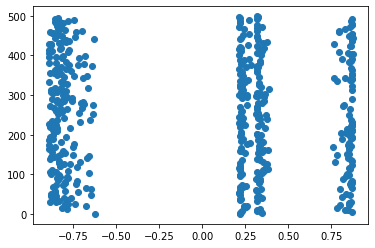

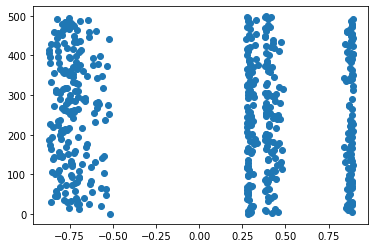

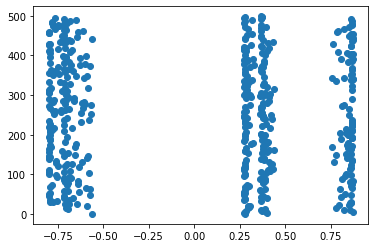

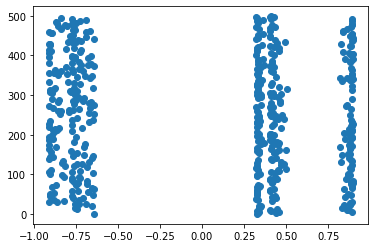

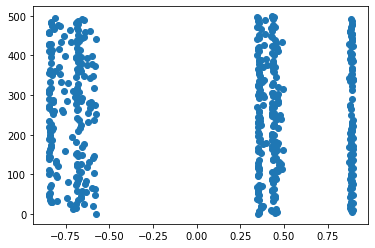

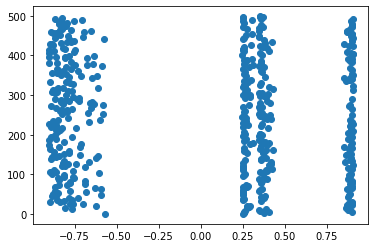

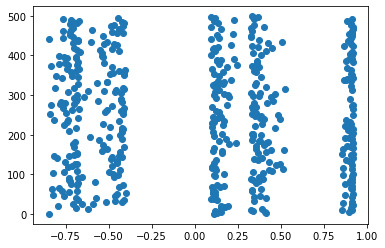

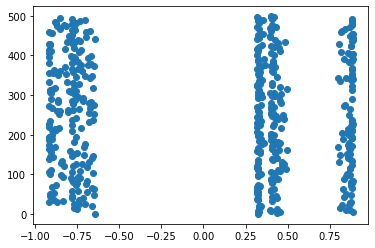

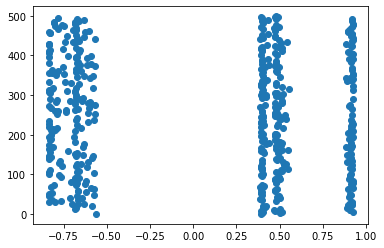

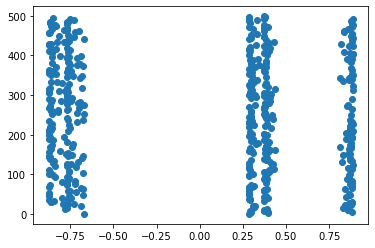

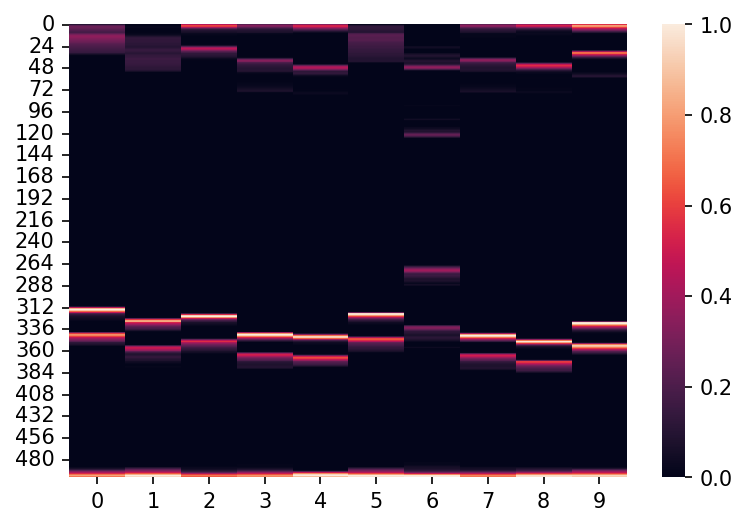

In [53]:
densities = []
X_plots = []

for i, net in enumerate(models):
    projection = project(net, ds)
    plt.figure()
    plt.scatter(projection, np.arange(len(projection)))
    X_plot = np.linspace(projection.min(), projection.max(), len(projection))[:, np.newaxis]
    X_plots.append(X_plot)
    kde = KernelDensity(kernel=kernel, bandwidth=0.005).fit(projection)
    log_dens = kde.score_samples(X_plot)
    log_dens[log_dens < 0] = 0
    log_dens = np.exp(log_dens)
    log_dens = (log_dens - np.min(log_dens)) / (np.max(log_dens) - np.min(log_dens))
    densities.append(log_dens)
densities = np.array(densities).T

# densities = densities.reshape(densities.shape[0], densities.shape[1]).T
# densities = (densities - np.min(densities)) / (np.max(densities) - np.min(densities))
import seaborn as sns

plt.figure(dpi=150)
sns.heatmap(densities)


In [46]:
from files.NeuralRansac import clustering
from files.utils.utility_functions import plot_clusters
prefs, cluss = clustering(densities)

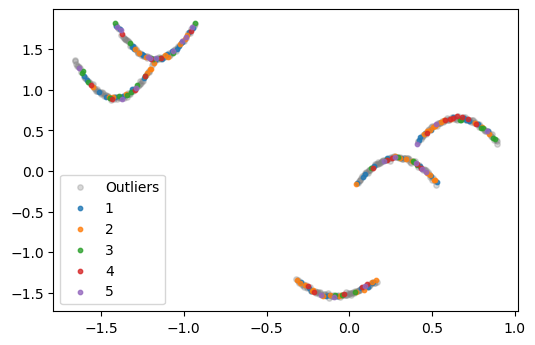

In [47]:
cluss.sort(key=lambda x: -len(x))
clusters = cluss.copy()

new_clusters = np.zeros(len(ds))
for i, cl in enumerate(clusters[:5]):
    for j, p in enumerate(cl):
        clusters[i][j] = p
    new_clusters[cl] = i+1
new_clusters = new_clusters.astype(int)
plot_clusters(clusters=new_clusters, data=ds)

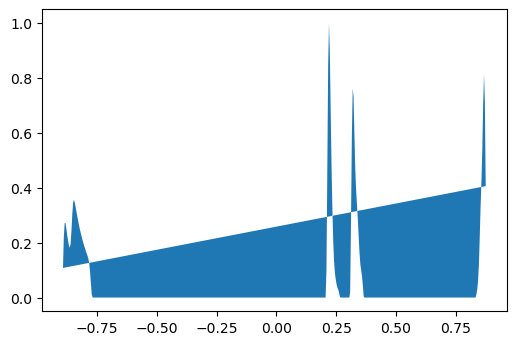

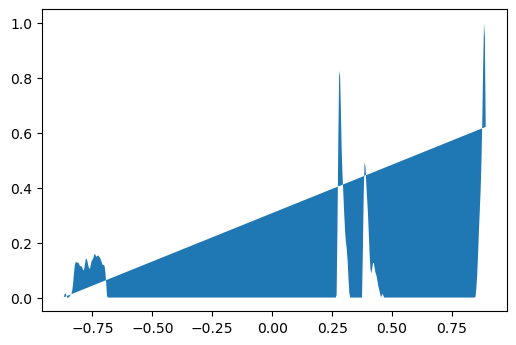

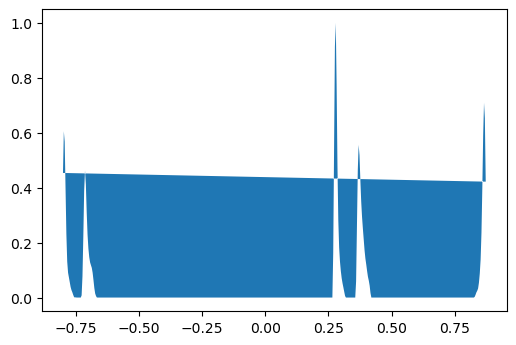

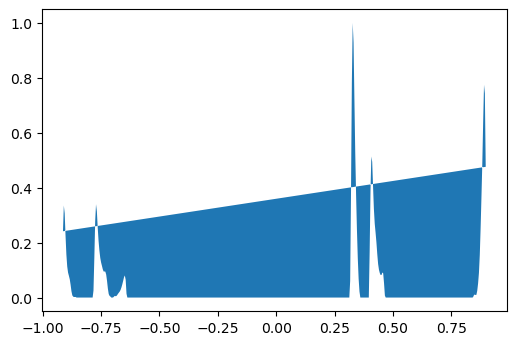

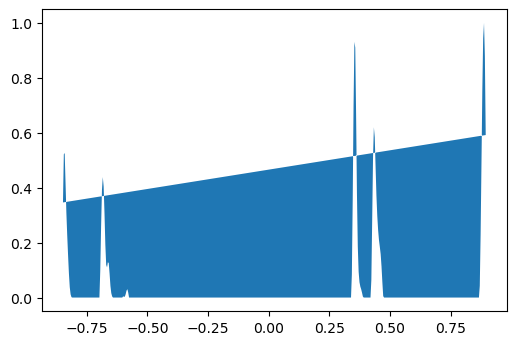

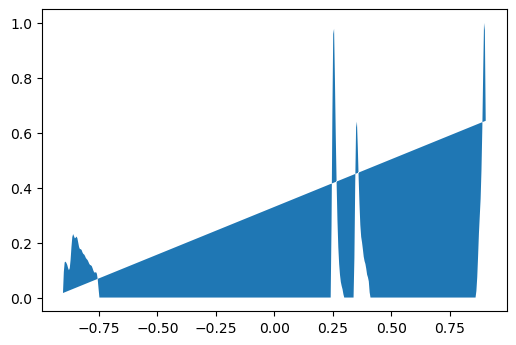

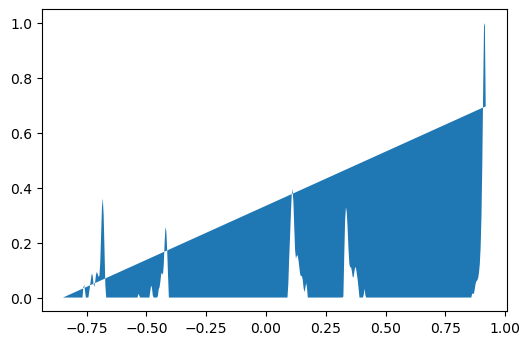

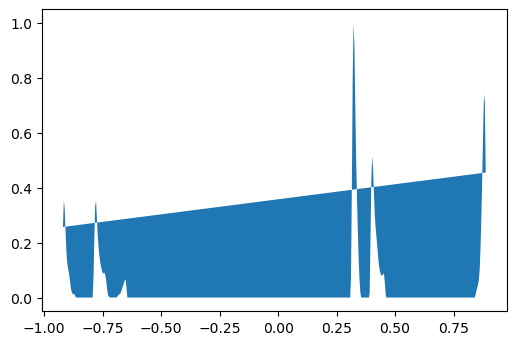

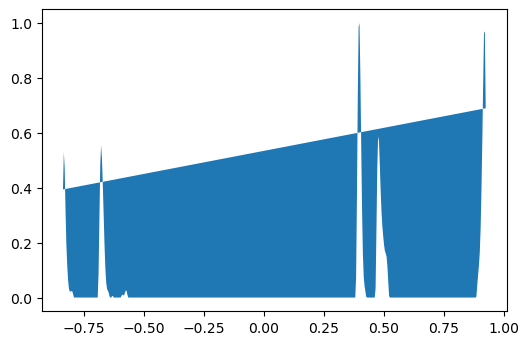

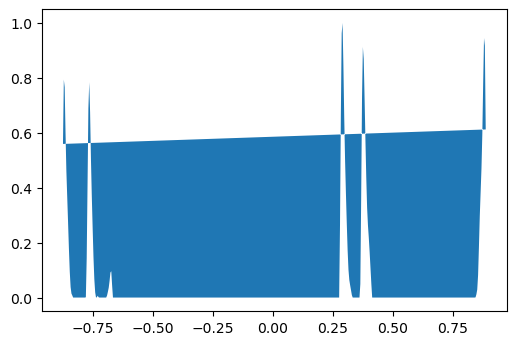

In [48]:
for density, X_plot in zip(densities.T, X_plots):
    plt.figure(dpi=100)
    plt.fill(X_plot, density)

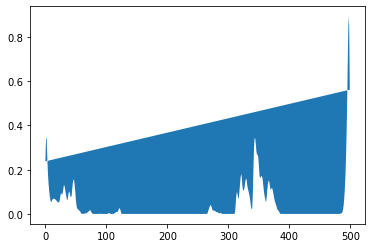

In [49]:
d = np.mean(densities, axis=1)

xplot = np.arange(len(d))
plt.fill(xplot, d)

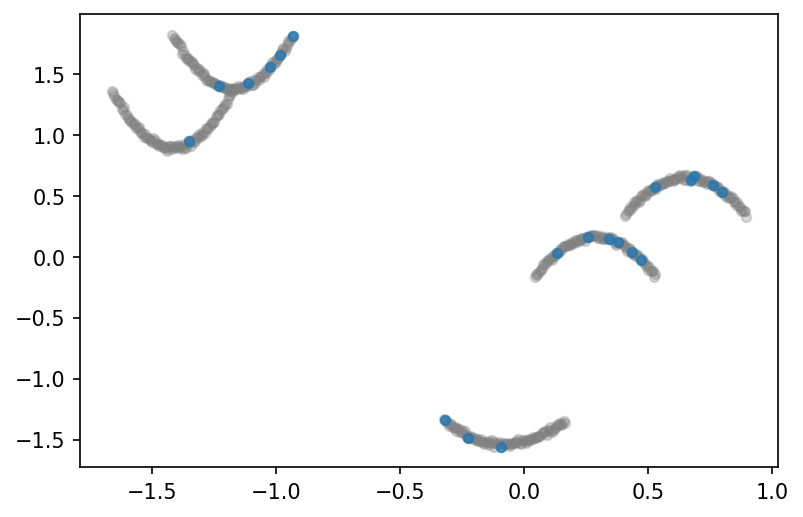

In [50]:
plot(ds, c='gray', alpha=0.3, new_fig=True)
plot(ds[d > 0.2])